# Lab 3

---------

CSC3310 - 002

Leena Afifi

Vlad Wilson

## Abstract

In this lab we implement an Algorithm for calculating whether a point is inside a polygon given it's verticies. We also perform comprehensive tests and benchmarking, plotting a table and a graph.

### Imports

In [1]:
from dataclasses import dataclass
from typing import List as TList, Dict, Any
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import time

### Algorithm Implemenation

In [2]:
from typing import List, Tuple

Point = Tuple[float, float]

def _point_on_segment(p: Point, a: Point, b: Point, eps: float = 1e-9) -> bool:
    """Return True if point p lies on the closed segment ab (with tolerance).
    
    Uses an area (cross product) collinearity test plus a bounding-box test.
    """
    (px, py), (x1, y1), (x2, y2) = p, a, b
    # Collinearity test via cross product area
    cross = (x2 - x1) * (py - y1) - (y2 - y1) * (px - x1)
    if abs(cross) > eps:
        return False
    # Within bounding box
    return (min(x1, x2) - eps <= px <= max(x1, x2) + eps and
            min(y1, y2) - eps <= py <= max(y1, y2) + eps)

def point_in_polygon(point: Tuple[float, float],
                     vertices: List[Tuple[float, float]]) -> bool:
    """
    Return True iff `point` is inside the simple polygon defined by `vertices`.
    Points on the boundary are considered inside.
    Runs in O(n) time where n = number of vertices.
    """
    px, py = point
    n = len(vertices)

    # 1) Boundary-inclusive check
    for i in range(n):
        a = vertices[i]
        b = vertices[(i + 1) % n]
        if _point_on_segment(point, a, b):
            return True

    # 2) Ray-casting to +x (even–odd rule)
    inside = False
    for i in range(n):
        x1, y1 = vertices[i]
        x2, y2 = vertices[(i + 1) % n]

        # Does the edge straddle the horizontal line y = py?
        # Using strict '>' ensures vertices are counted once.
        if (y1 > py) != (y2 > py):
            # x coordinate where the edge intersects y = py
            xinters = x1 + (py - y1) * (x2 - x1) / (y2 - y1)  # y2 != y1 here
            if xinters >= px - 1e-9:  # intersection to the right of the point
                inside = not inside

    return inside

### Helper class and function for Testing

In [3]:
@dataclass
class TestCase:
    """
    A single test case for point-in-polygon.
    """
    name: str
    polygon: TList[Point]
    point: Point
    expected: bool

def regular_ngon(n: int, r: float = 10.0, cx: float = 0.0, cy: float = 0.0) -> TList[Point]:
    """
    Generate a counterclockwise regular n-gon centered at (cx, cy) with radius r.
    """
    return [(cx + r * math.cos(2 * math.pi * k / n),
             cy + r * math.sin(2 * math.pi * k / n)) for k in range(n)]



### Perform Tests and store results

In [4]:
def run_tests() -> pd.DataFrame:
    """
    Run tests and return a DataFrame of results (expected vs. actual).
    """
    tri = [(0,0), (10,0), (5,10)]
    concave = [(0,0), (4,0), (4,4), (2,2), (0,4)]
    rect = [(0,0), (10,0), (10,5), (0,5)]
    neg = [(-5,-5), (-1,-5), (-1,-1), (-5,-1)]
    flat_edge = [(0,0), (10,0), (10,10), (0,10)]
    vertical_edge = [(0,0), (0,10), (5,10), (5,0)]

    tests: TList[TestCase] = [
        TestCase("triangle_inside", tri, (5,2), True),
        TestCase("triangle_on_edge", tri, (2.5,5), True),
        TestCase("triangle_on_vertex", tri, (0,0), True),
        TestCase("triangle_outside", tri, (11,0), False),

        TestCase("concave_inside", concave, (3,1), True),
        TestCase("concave_outside", concave, (3,3.5), False),
        TestCase("concave_on_reflex_edge", concave, (3,3), True),

        TestCase("rectangle_inside", rect, (9.9,4.9), True),
        TestCase("rectangle_outside", rect, (10.1,2.5), False),
        TestCase("rectangle_on_edge", rect, (10,2.5), True),

        TestCase("negative_inside", neg, (-2,-3), True),
        TestCase("negative_outside", neg, (0,0), False),
        TestCase("negative_on_edge", neg, (-3,-5), True),

        TestCase("flat_edge_on_edge", flat_edge, (5,0), True),
        TestCase("flat_edge_outside", flat_edge, (5,-0.1), False),
        TestCase("vertical_edge_on_edge", vertical_edge, (0,7), True),
        TestCase("vertical_edge_outside", vertical_edge, (-0.1,7), False),

        TestCase("regular_ngon_inside", regular_ngon(12, r=5), (0,0), True),
        TestCase("regular_ngon_outside", regular_ngon(12, r=5), (10,10), False),
    ]

    rows: TList[Dict[str, Any]] = []

    for tc in tests:
        try:
            actual = point_in_polygon(tc.point, tc.polygon)
        except Exception as e:
            actual = f"Error: {e}"
        rows.append({
            "name": tc.name,
            "point": tc.point,
            "expected": tc.expected,
            "actual": actual,
            "pass": (actual == tc.expected),
        })
    df = pd.DataFrame(rows)
    
    return df

### Display results

In [5]:
df_results = run_tests()
display(df_results)

,name,point,expected,actual,pass
0,triangle_inside,"(5, 2)",True,True,True
1,triangle_on_edge,"(2.5, 5)",True,True,True
2,triangle_on_vertex,"(0, 0)",True,True,True
3,triangle_outside,"(11, 0)",False,False,True
4,concave_inside,"(3, 1)",True,True,True
5,concave_outside,"(3, 3.5)",False,False,True
6,concave_on_reflex_edge,"(3, 3)",True,True,True
7,rectangle_inside,"(9.9, 4.9)",True,True,True
8,rectangle_outside,"(10.1, 2.5)",False,False,True
9,rectangle_on_edge,"(10, 2.5)",True,True,True


### Benchamrking Function

In [6]:
def benchmark_point_in_polygon(
    sizes,
    inside_point=(0.0, 0.0),
    trials_small: int = 10,
    trials_large: int = 3,
    split: int = 5000
) -> pd.DataFrame:
    """Benchmark point_in_polygon for various n and return timing stats.

    Args:
        sizes: Iterable of polygon vertex counts (n).
        inside_point: Point near center; inside for convex regular polygons.
        trials_small: Trials when n <= split.
        trials_large: Trials when n > split.
        split: Switch to fewer trials beyond this size.

    Returns:
        DataFrame with columns: n_vertices, trials, time_mean, time_std, time_min, time_max.
    """
    records = []
    pregen = {n: regular_ngon(n) for n in sizes} # pre-generate polygons

    for n in sizes:
        polygon = pregen[n]
        trials = trials_small if n <= split else trials_large

        times = []
        for _ in range(trials):
            t0 = time.perf_counter()
            _ = point_in_polygon(inside_point, polygon)
            t1 = time.perf_counter()
            times.append((t1 - t0))

        arr = np.array(times, dtype=float)
        records.append({
            "n_vertices": n,
            "trials": trials,
            "time_mean": float(arr.mean()),
            "time_std": float(arr.std(ddof=1)) if trials > 1 else 0.0,
            "time_min": float(arr.min()),
            "time_max": float(arr.max()),
        })

    df = pd.DataFrame.from_records(records).sort_values("n_vertices").reset_index(drop=True)
    return df

### Run Benchmarks

In [7]:
sizes = [20000, 40000, 80000, 160000, 320000, 640000, 1280000, 2560000, 5120000]
bench_df = benchmark_point_in_polygon(sizes)
display(bench_df)

,n_vertices,trials,time_mean,time_std,time_min,time_max
0,20000,3,0.003253,0.000027,0.003230,0.003282
1,40000,3,0.006600,0.000088,0.006499,0.006652
2,80000,3,0.013148,0.000321,0.012899,0.013510
3,160000,3,0.026566,0.000181,0.026364,0.026716
4,320000,3,0.052469,0.000204,0.052307,0.052698
5,640000,3,0.106282,0.001114,0.105586,0.107567
6,1280000,3,0.217385,0.005452,0.213142,0.223534
7,2560000,3,0.429001,0.004280,0.424090,0.431934
8,5120000,3,0.854704,0.002835,0.851433,0.856434


### Plot Results

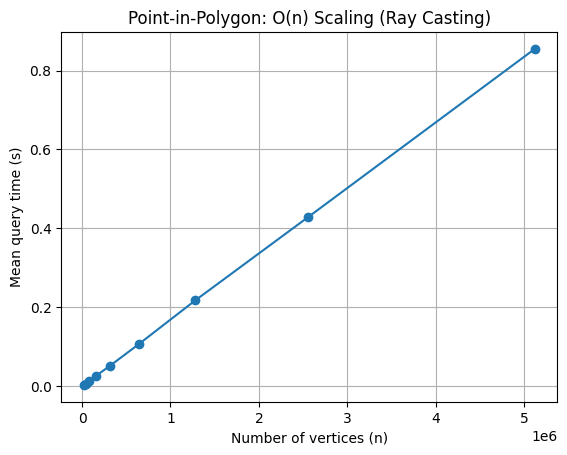

In [8]:
plt.figure()
plt.plot(bench_df["n_vertices"], bench_df["time_mean"], marker="o")
plt.xlabel("Number of vertices (n)")
plt.ylabel("Mean query time (s)")
plt.title("Point-in-Polygon: O(n) Scaling (Ray Casting)")
plt.grid(True)
plt.show()

### Conclusion

In this project, we implemented an algorithm to determine whether a given point lies inside, outside, or on the boundary of a polygon. The approach used the ray-casting (even–odd) rule, which counts intersections between a horizontal ray extending from the test point and the polygon’s edges. To ensure boundary inclusiveness, an additional check was implemented to detect when the point lies exactly on an edge or vertex of the polygon. We verified the correctness of the algorithm using several test cases with both convex and concave polygons, as well as points on edges and corners. Benchmarking results confirmed that the algorithm runs in linear time O(n), consistent with theoretical expectations, where n is the number of polygon vertices.